# Description of problems

Let $D = \{(x_i, y_i)\}_{i=1}^N$ be a training dataset. The goal is to train a linear classifier in a form of $y(x) = sign(x^Tw + b)$

## SVM with soft-margins
__Primal problem__

$$ \min_{\xi_i, w, b} \sum_{i=1}^N \xi_i + C\|w\|_2^2$$
$$\text{s.t.} ~~~~ y_i (x_i^Tw + b) \geq 1 - \xi_i$$
$$ \xi_i \geq 0 $$

Lets rewrite the conditions on $\xi_i$:
$$
\begin{cases}
\xi_i \geq& 1 - y_i (x_i^Tw + b) \\
\xi_i \geq& 0
\end{cases}
$$
taking into account this conditions and the fact that in the objective we want to minimize $\xi_i$ we may conclude that:

$$\xi_i = \max(0, 1 - y_i (x_i^Tw + b))$$

And the optimization problem can be formulated as follows:

$$ \min_{\xi_i, w, b} \sum_{i=1}^N \max(0, 1 - y_i (x_i^Tw + b)) + C\|w\|_2^2$$



## Logistic Regression

In logistic regression we model the $p(y=+1|x)$ via linear function and sigmoid:
$$ p(y=+1|x) = y(x) = \sigma(x^Tw + b) = \dfrac{1}{1 + e^{-(x^Tw + b)}} $$

To find the parameters $w, b$ we follow maximum-likelihood approach, and the optimization problem is the following:

$$ \max_{w, b} \sum_{i=1}^N [y_i = +1]\log(\sigma(x^Tw + b)) + [y_i = -1]\log(1 - \sigma(x^Tw + b)) $$

For each classifier and dataset we tune the regularisation hyperparameter on the validation set and then results are for the test set with best hyperparameter.

In [1]:
from cvxpysvm import SVM, SVMPrimal, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from hyperopt import fmin, tpe, hp
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
from skrvm import RVC

In [3]:
def objective(clf, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
    clf.fit(X_train, y_train)
    return 1 - (clf.predict(X_val) == y_val).mean()

def accuracy(clf, X, y, sparsity=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    obj = lambda params: objective(clf(**params), X=X_train, y=y_train)
    space = {"lambd" : hp.loguniform('lambd', -3, 2.)}
    best = fmin(obj, space, algo=tpe.suggest, max_evals=50, rstate=np.random.RandomState(42))
    print("Best Lambda: ", best["lambd"])
    best_clf = clf(best["lambd"])
    best_clf.fit(X_train, y_train)
    if sparsity:
        print("Sparsity: ", best_clf.sparsity)
    return (best_clf.predict(X_test) == y_test).mean()

# Synthetic task

In [ ]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)
X = StandardScaler().fit_transform(X)

In [ ]:
np.random.seed(42)
accuracy(SVMPrimal, X, y)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: LogisticRegression(lambd, norm=2), X, y)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: LogisticRegression(lambd, norm=1), X, y, sparsity=True)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: SVM(C=lambd, kernel="linear"), X, y, sparsity=True)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: SVM(C=lambd, kernel="poly"), X, y, sparsity=True)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: SVM(C=lambd, kernel="rbf"), X, y, sparsity=True)

# Breast cancer data

In [4]:
data = pd.read_csv("./Breast_cancer_data.csv")

In [5]:
data.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


In [6]:
y = data["diagnosis"].values
X = data.drop("diagnosis", axis=1).values

In [7]:
X = StandardScaler().fit_transform(X)

In [ ]:
np.random.seed(42)
accuracy(SVMPrimal, X, y)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: LogisticRegression(lambd, norm=2), X, y)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: LogisticRegression(lambd, norm=1), X, y, sparsity=True)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: SVM(C=lambd, kernel="linear"), X, y, sparsity=True)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: SVM(C=lambd, kernel="poly"), X, y, sparsity=True)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: SVM(C=lambd, kernel="rbf"), X, y, sparsity=True)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.random.seed(42)
clf = RVC(kernel="linear")
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print("Sparsity: ", 1 - ((len(clf.m_) - 1) / X_train.shape[0]))

0.9473684210526315
Sparsity:  0.9956043956043956


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.random.seed(42)
clf = RVC(kernel="poly")
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print("Sparsity: ", 1 - ((len(clf.m_) - 1) / X_train.shape[0]))

0.956140350877193
Sparsity:  0.9956043956043956


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.random.seed(42)
clf = RVC(kernel="rbf")
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print("Sparsity: ", 1 - ((len(clf.m_) - 1) / X_train.shape[0]))

0.9649122807017544
Sparsity:  0.9868131868131869


# Pima Indians diabetes data

In [11]:
data = pd.read_csv("./PimaIndians.csv")

In [12]:
data.head()

,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,test
0,1,89,66,23,94,28.1,0.167,21,negatif
1,0,137,40,35,168,43.1,2.288,33,positif
2,3,78,50,32,88,31.0,0.248,26,positif
3,2,197,70,45,543,30.5,0.158,53,positif
4,1,189,60,23,846,30.1,0.398,59,positif


In [13]:
y = data["test"].values
X = data.drop("test", axis=1).values

In [14]:
X = StandardScaler().fit_transform(X)

In [15]:
y[y == 'negatif'] = 0
y[y == 'positif'] = 1

In [16]:
y = y.astype(np.int64)

In [ ]:
np.random.seed(42)
accuracy(SVMPrimal, X, y)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: LogisticRegression(lambd, norm=2), X, y)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: LogisticRegression(lambd, norm=1), X, y, sparsity=True)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: SVM(C=lambd, kernel="linear"), X, y, sparsity=True)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: SVM(C=lambd, kernel="poly"), X, y, sparsity=True)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: SVM(C=lambd, kernel="rbf"), X, y, sparsity=True)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.random.seed(42)
clf = RVC(kernel="linear")
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print("Sparsity: ", 1 - ((len(clf.m_) - 1) / X_train.shape[0]))

0.7721518987341772
Sparsity:  0.9904153354632588


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.random.seed(42)
clf = RVC(kernel="poly")
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print("Sparsity: ", 1 - ((len(clf.m_) - 1) / X_train.shape[0]))

0.7341772151898734
Sparsity:  0.9456869009584664


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.random.seed(42)
clf = RVC(kernel="rbf")
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print("Sparsity: ", 1 - ((len(clf.m_) - 1) / X_train.shape[0]))

0.7341772151898734
Sparsity:  0.9584664536741214


# Banknote dataset

In [20]:
data = pd.read_csv("banknote.csv", header=None)

In [21]:
data.head()

,0,1,2,3,4
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [22]:
y = data[4].values
X = data.drop(4, axis=1).values

In [23]:
X = StandardScaler().fit_transform(X)

In [ ]:
np.random.seed(42)
accuracy(SVMPrimal, X, y)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: LogisticRegression(lambd, norm=2), X, y)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: LogisticRegression(lambd, norm=1), X, y, sparsity=True)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: SVM(C=lambd, kernel="linear"), X, y, sparsity=True)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: SVM(C=lambd, kernel="poly"), X, y, sparsity=True)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: SVM(C=lambd, kernel="rbf"), X, y, sparsity=True)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.random.seed(42)
clf = RVC(kernel="linear")
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print("Sparsity: ", 1 - ((len(clf.m_) - 1) / X_train.shape[0]))

0.9854545454545455
Sparsity:  0.9963536918869644


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.random.seed(42)
clf = RVC(kernel="poly")
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print("Sparsity: ", 1 - ((len(clf.m_) - 1) / X_train.shape[0]))

1.0
Sparsity:  0.9945305378304466


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.random.seed(42)
clf = RVC(kernel="rbf")
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print("Sparsity: ", 1 - ((len(clf.m_) - 1) / X_train.shape[0]))

0.9927272727272727
Sparsity:  0.9981768459434822


# Ionosphere dataset

In [27]:
data = pd.read_csv("ionosphere.csv", header=None)

In [28]:
y = data[34].values
y[y == "b"] = 0
y[y == "g"] = 1
X = data.drop(34, axis=1).values

In [29]:
X = StandardScaler().fit_transform(X)

In [30]:
y = y.astype(np.int64)

In [ ]:
np.random.seed(42)
accuracy(SVMPrimal, X, y)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: LogisticRegression(lambd, norm=2), X, y)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: LogisticRegression(lambd, norm=1), X, y, sparsity=True)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: SVM(C=lambd, kernel="linear"), X, y, sparsity=True)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: SVM(C=lambd, kernel="rbf"), X, y, sparsity=True)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: SVM(C=lambd, kernel="poly"), X, y, sparsity=True)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.random.seed(42)
clf = RVC(kernel="linear")
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print("Sparsity: ", 1 - ((len(clf.m_) - 1) / X_train.shape[0]))

0.8732394366197183
Sparsity:  0.9678571428571429


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.random.seed(42)
clf = RVC(kernel="poly")
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print("Sparsity: ", 1 - ((len(clf.m_) - 1) / X_train.shape[0]))

/Users/agadetsky/.pyenv/versions/3.6.6/lib/python3.6/site-packages/skrvm/rvm.py:239: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1-y[t == 0]), 0))
/Users/agadetsky/.pyenv/versions/3.6.6/lib/python3.6/site-packages/skrvm/rvm.py:239: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1-y[t == 0]), 0))
/Users/agadetsky/.pyenv/versions/3.6.6/lib/python3.6/site-packages/skrvm/rvm.py:239: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1-y[t == 0]), 0))
/Users/agadetsky/.pyenv/versions/3.6.6/lib/python3.6/site-packages/skrvm/rvm.py:239: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1-y[t == 0]), 0))
/Users/agadetsky/.pyenv/versions/3.6.6/lib/python3.6/site-packages/skrvm/rvm.py:239: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1-y[t == 0]), 0))
/Users/agadetsky/.pyenv/versions/3.6.6/lib/python3.6/site-packages/skrvm/rvm.py:239: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1-y[

0.8732394366197183
Sparsity:  0.9535714285714285


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.random.seed(42)
clf = RVC(kernel="rbf")
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print("Sparsity: ", 1 - ((len(clf.m_) - 1) / X_train.shape[0]))

0.971830985915493
Sparsity:  0.9607142857142857


# Wine dataset

In [34]:
data = pd.read_csv("wine.csv", header=None)

In [35]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [36]:
y = data[0].values
y[y <= 1] = 0
y[y > 1] = 1
X = data.drop(0, axis=1).values

In [37]:
X = StandardScaler().fit_transform(X)

In [ ]:
np.random.seed(42)
accuracy(SVMPrimal, X, y)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: LogisticRegression(lambd, norm=2), X, y)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: LogisticRegression(lambd, norm=1), X, y, sparsity=True)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: SVM(C=lambd, kernel="linear"), X, y, sparsity=True)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: SVM(C=lambd, kernel="poly"), X, y, sparsity=True)

In [ ]:
np.random.seed(42)
accuracy(lambda lambd: SVM(C=lambd, kernel="rbf"), X, y, sparsity=True)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.random.seed(42)
clf = RVC(kernel="linear")
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print("Sparsity: ", 1 - ((len(clf.m_) - 1) / X_train.shape[0]))

1.0
Sparsity:  0.971830985915493


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.random.seed(42)
clf = RVC(kernel="linear")
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print("Sparsity: ", 1 - ((len(clf.m_) - 1) / X_train.shape[0]))

1.0
Sparsity:  0.971830985915493


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.random.seed(42)
clf = RVC(kernel="linear")
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print("Sparsity: ", 1 - ((len(clf.m_) - 1) / X_train.shape[0]))

1.0
Sparsity:  0.971830985915493


# SVM: MNIST

In [445]:
from sklearn import datasets
from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [446]:
mnist = fetch_mldata('MNIST original', data_home='./')

In [447]:
images = mnist.data
targets = mnist.target

In [448]:
X_0 = images[targets == 1]
X_1 = images[targets == 8]
y_0 = targets[targets == 1]
y_1 = targets[targets == 8]

In [449]:
_X = np.vstack([X_0, X_1])
y = np.hstack([y_0, y_1])

In [450]:
np.random.seed(42)
shuffle_idx = np.arange(X.shape[0])
np.random.shuffle(shuffle_idx)
_X = _X[shuffle_idx]
y = y[shuffle_idx]
X = StandardScaler().fit_transform(_X.astype(np.float64) / 255)

In [451]:
X_train, X_test, y_train, y_test = train_test_split(X[:2000], y[:2000], test_size=0.2, random_state=42)

In [452]:
clf = SVM(C=.1, kernel="linear")


clf.fit(X_train, y_train)

np.mean(clf.predict(X_test) == y_test)

0.98

In [453]:
print('sparsity rate {:.3f}'.format(clf.sparsity))

sparsity rate 0.838


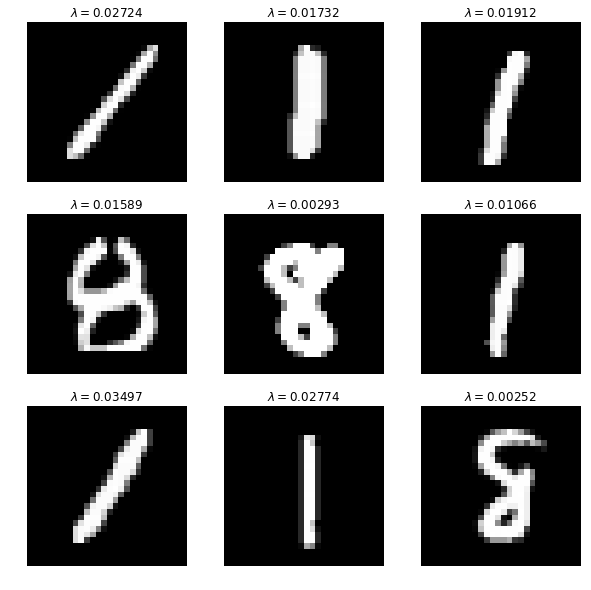

In [454]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.title(r'$\lambda = ${:.5f}'.format(clf.lambd[order[i]]))
    plt.imshow(_X[order[i]].reshape((28, 28)), cmap='gray')
    plt.axis('off')
plt.savefig('mnist.png', dpi=300, bbox_inches='tight')